# Implementação de um codigo de Eigenfaces

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$','$'], ['\\(','\\)']],
processEscapes: true},
jax: ["input/TeX","input/MathML","input/AsciiMath","output/CommonHTML"],
extensions: ["tex2jax.js","mml2jax.js","asciimath2jax.js","MathMenu.js","MathZoom.js","AssistiveMML.js", "[Contrib]/a11y/accessibility-menu.js"],
TeX: {
extensions: ["AMSmath.js","AMSsymbols.js","noErrors.js","noUndefined.js"],
equationNumbers: {
autoNumber: "AMS"
}
}
});
</script>
<p style="opacity: 0.5">< ⚙️ Magical code to run latex on markdown here ></p>

A idea por trás dos algoritmos de eigenfaces é interpretar imagens como vetores para então aplicar conceitos de algebra linear e conseguir resultados interessantes.
No algoritmo em questão, fazemos uma matriz onde cada coluna representa uma imagem. A partir dela geramos uma matriz de covariancia, multiplicando a matriz das imagens pela sua transversa.
Dessa nova matriz, extraímos os autovalores e autovetores, e ordenamos eles conforme os autovalores mais altos, que representam o peso que aquele vetor componente possui nas descrições das imagens.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Para a leitura de imagens eu roubei esse codigo que é muito interessante

In [5]:
IMAGE_DIR = 'training-images'
DEFAULT_SIZE = [250, 250] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name))
            image = image.convert ("L")
            # resize to given size (if given )
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir)
    return [images,images_names]



In [54]:
[X, y] = read_images()
print("Exemplo de como uma imagem está armazenada (X[0]): ")
print(X[0])
print(type(X[0]))
print("Numero de arrays dentro desse primeiro array (tamanho de X[0]):")
print(len(X[0]))
print("Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):")
print(len(X[0][0]))
print("Ou seja, cada imagem está armazenada como uma lista com 250 'linhas', onde cada linha tem 250 entradas, cada uma correspondente a um pixel da imagem.")

Exemplo de como uma imagem está armazenada (X[0]): 
[[  0   0   0 ...   1   1   1]
 [  0   0   0 ...   0   0   0]
 [  0   0   1 ...   3   3   3]
 ...
 [119 125 133 ... 130 143 150]
 [118 120 127 ... 137 150 157]
 [114 116 123 ... 143 154 161]]
<class 'numpy.ndarray'>
Numero de arrays dentro desse primeiro array (tamanho de X[0]):
250
Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):
250
Ou seja, cada imagem está armazenada como uma lista com 250 'linhas', onde cada linha tem 250 entradas, cada uma correspondente a um pixel da imagem.


In [39]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )


total face-count:  53


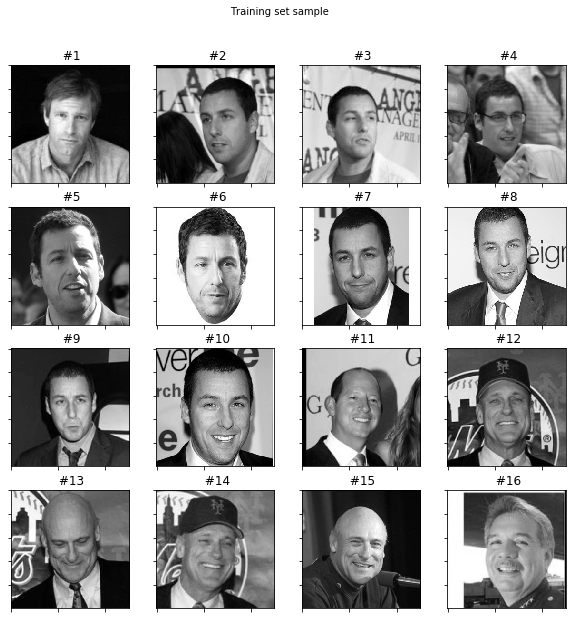

In [55]:
E = []
number = len(X)
for i in range (min(number, 16)):
    E.append(np.asarray(X[i]))
# plot them and store the plot to " python_eigenfaces .pdf"
subplot ( title ="Training set sample", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="sample-of-initial-faces.png")
print("total face-count: ",number)

Agora para prosseguir com os calculos precisamos que cada imagem seja um vetor de valores reais, e não uma lista de listas, para isso, as informações dos valores de cada pixel serão ordenados e transformados em um vetor com 250x250=62500 entradas.

In [56]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    return mat

In [66]:
images_as_rows = as_row_matrix(X)
print("Shape da matriz (colunas = imagens, linhas = pixels da imagem)")
images_as_rows.shape

Shape da matriz (colunas = imagens, linhas = pixels da imagem)


(53, 62500)

Temos então $ X= \begin{bmatrix}F_1 & F_2 & ... & F_n \end{bmatrix} $
Com $F_{1xn}$ com $n$ sendo o nosso numero de pixels por imagem

Agora que cada imagem é um vetor, é possivel realizar operações entre vetores e exibir um vetor como uma imagem, um exemplo disso é o vetor médio $m$, ou a face média, obtida pela media dos vetores:

$m = \frac{1}{n}\sum_{i=1}^{i=n} F_i $

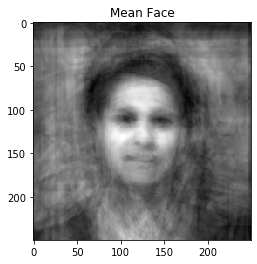

In [63]:
average_weight_matrix = np.reshape(images_as_rows.mean( axis =0), X[0].shape)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()